In [1]:
# from time import sleep
# from modules.util import jsonify, time_gap, save_json
# from modules.crawl import reviewAPI


In [2]:
# # Constant Setting
# HAS_NEXT_PAGE = True
# NEXT_CURSOR = ""
# crawled_reviews = {}

# #  Crawling
# while HAS_NEXT_PAGE:
#     # API Requests
#     next_reviews = (
#         reviewAPI().get(uuid="0f101f8c-ec09-39c4-9be0-2f9cc464d332", cursor=NEXT_CURSOR, page_count=20).text
#     )
#     next_reviews = jsonify(next_reviews)

#     # Save as Dictionary
#     if len(crawled_reviews) == 0:
#         crawled_reviews = next_reviews
#     else:
#         crawled_reviews["reviews"].extend(next_reviews["reviews"])

#     # Next Request Conditions
#     HAS_NEXT_PAGE = next_reviews["pageInfo"]["hasNextPage"]
#     NEXT_CURSOR = (
#         next_reviews["pageInfo"]["endCursor"]
#         if ("endCursor" in next_reviews["pageInfo"].keys()) & HAS_NEXT_PAGE
#         else ""
#     )

#     # Time Delay
#     sleep(time_gap(mu=4))

# # Save Dictionary to JSON files
# save_json("./database/venom_review.json", crawled_reviews)

In [ ]:
import json
import numpy as np  
import pandas as pd
with open("../database/venom_review.json", 'r', encoding='utf-8') as file:
    data = json.load(file)
quotes = [item["quote"] for item in data["reviews"]]
sentiment=[item["scoreSentiment"] for item in data["reviews"]]

df = pd.DataFrame({
    "review": quotes,
    "sentiment": sentiment
})

df

,review,sentiment
0,Sadly&#44; the film stumbles through a series ...,NEGATIVE
1,There's plenty of satisfying set pieces here a...,POSITIVE
2,It’s Tom Hardy show and as expected he hits th...,POSITIVE
3,This is a flawed&#44; but enjoyable movie desp...,POSITIVE
4,Despite featuring a Venom horse and Venom danc...,NEGATIVE
...,...,...
168,A futile third Venom movie that fails to give ...,NEGATIVE
169,As the film progresses&#44; it consistently es...,POSITIVE
170,In a whirlwind of chaotic creativity&#44; Veno...,NEGATIVE
171,“The Last Dance” brings nothing new to the ser...,NEGATIVE


In [4]:
# NOTE: unique value가 2인 것을 통해 IMDB 데이터셋에서 감정Label(Sentiment)는 positive, negative 두가지 인 것을 알 수 있다.
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     173 non-null    object
 1   sentiment  173 non-null    object
dtypes: object(2)
memory usage: 2.8+ KB
None
                                                   review sentiment
count                                                 173       173
unique                                                172         2
top     This is the weakest of the three&#44; mostly b...  NEGATIVE
freq                                                    2       105


In [5]:
df["sentiment"].value_counts()

sentiment
NEGATIVE    105
POSITIVE     68
Name: count, dtype: int64

In [6]:
# 데이터가 중복되는 것이 있는지 확인
# NOTE: 중복되는 entry가 있는 것을 알 수 있다. 제거 필수!!
duplicates = df[df.duplicated()]  
print("have duplicates:", len(duplicates) != 0)

have duplicates: True


In [7]:
# 중복되는 entry 제거하기.
df = df.drop_duplicates(subset='review') # 중복되는 행 제거
df["sentiment"].value_counts()

sentiment
NEGATIVE    105
POSITIVE     67
Name: count, dtype: int64

In [8]:
# 긍정/부정:string을 컴퓨터가 사용할 수 있게 1/0:int으로 대응(mapping)
df.loc[:, 'sentiment'] = df['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': 0})
df.loc[:, 'sentiment'].value_counts()

sentiment
0    105
1     67
Name: count, dtype: int64

C:\Users\hjo40\AppData\Local\Temp\ipykernel_29368\1726311597.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_cleaned'] = df['review'].apply(clean_text)


<Axes: ylabel='Frequency'>

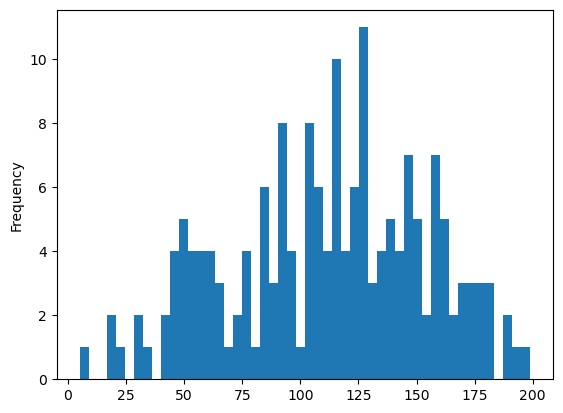

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import re
def clean_text(text):
    text = text.lower() # 소문자화
    text = re.sub(r"<.*?>", "", text) # HTML태그 제거 
    text = re.sub(r"[^.a-z\s!?']", "", text) # 특수 문자 및 숫자 제거
    text = " ".join(word for word in text.split() if word not in stop_words) # 불용어 제거
    text = re.sub(r'([!?\'"])\1+', r'\1', text) # !?'이 2개 이상이면 한 개로 만들어줌.
    text = re.sub(r'\s+', ' ', text).strip() # 불필요한 공백 제거
    return text
df['review_cleaned'] = df['review'].apply(clean_text)
pd.Series([len(review) for review in df["review_cleaned"].to_list()]).plot.hist(bins=50)

In [ ]:
from modules.util import save_pkl
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
df["review_token"] =  tokenizer(df["review_cleaned"].to_list())["input_ids"]
df.head()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

c:\Users\hjo40\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hjo40\.cache\huggingface\hub\models--bert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

C:\Users\hjo40\AppData\Local\Temp\ipykernel_29368\1573987894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review_token"] =  tokenizer(df["review_cleaned"].to_list())["input_ids"]


,review,sentiment,review_cleaned,review_token
0,Sadly&#44; the film stumbles through a series ...,0,sadly film stumbles series missteps leaving ev...,"[101, 17156, 1273, 24545, 1116, 1326, 5529, 21..."
1,There's plenty of satisfying set pieces here a...,1,there's plenty satisfying set pieces great sou...,"[101, 1175, 112, 188, 7722, 18330, 1383, 3423,..."
2,It’s Tom Hardy show and as expected he hits th...,1,tom hardy show expected hits ball park dual ro...,"[101, 1106, 1306, 1662, 1183, 1437, 2637, 4919..."
3,This is a flawed&#44; but enjoyable movie desp...,1,flawed enjoyable movie despite inconsistencies...,"[101, 22593, 21449, 24815, 2523, 2693, 1107, 7..."
4,Despite featuring a Venom horse and Venom danc...,0,despite featuring venom horse venom dancing mr...,"[101, 2693, 3022, 22638, 3241, 22638, 5923, 18..."


In [15]:
print(sample_info := df["sentiment"].value_counts().to_dict())
negative_num, postive_num = sample_info.values()

{0: 105, 1: 67}


In [28]:
df["padded_token"] = df["review_token"].apply(lambda _X: _X[:-1] + [0] * (512 - len(_X[:-1]) - 1) + [102])
print(len(df["padded_token"].iloc[0]))
df.head(1)

512


C:\Users\hjo40\AppData\Local\Temp\ipykernel_29368\3977435679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["padded_token"] = df["review_token"].apply(lambda _X: _X[:-1] + [0] * (512 - len(_X[:-1]) - 1) + [102])


,review,sentiment,review_cleaned,review_token,token_length,padded_token
0,Sadly&#44; the film stumbles through a series ...,0,sadly film stumbles series missteps leaving ev...,"[101, 17156, 1273, 24545, 1116, 1326, 5529, 21...",27,"[101, 17156, 1273, 24545, 1116, 1326, 5529, 21..."
